In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py 
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']
phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
DL1r_keys = list(filter(lambda a: 'DL1r' in a, dataset.keys()))

Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  500000

In [2]:
import scale_variables
import shape_timesteps

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'cart_pt', 'eta':'meanmax', 'phi':'sincos', 'DL1r':'DL1r', 'm':'meanmax', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(Y_keys, Y_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 9.663381206337363e-13


In [3]:
# Create X and test array
split = int(np.floor(0.9*crop0)) # 80/20 split 

trainY, testY = Y_total[0:split,:], Y_total[split:,:]

timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)
    
    
trainX_jets, testX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, testX_other = totalX_other[0:split,:], totalX_other[split:,:]

# Save some memory 
del totalX_jets
del totalX_other 

print(trainX_jets.shape, trainX_other.shape, trainY.shape)
print(testX_jets.shape, testX_other.shape, testY.shape)

(450000, 6, 6) (450000, 7) (450000, 21)
(50000, 6, 6) (50000, 7) (50000, 21)


In [4]:
# Histograms of total  Y variables 
show = False

other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-1, 1, 40)
pt_bins = np.linspace(-1, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

In [5]:
# Histograms of X variables (without the mask)
show = False

if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

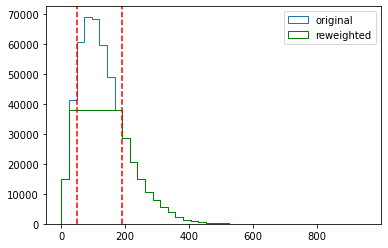

In [6]:
th_pt = np.array(dataset.get('th_pt'))[0:crop0]
hist1, bins = np.histogram(th_pt, 40)
hist1 = hist1 + (hist1<=0)*1
bins[-1] = np.inf
plt.hist(th_pt, 40, histtype='step', label='original')
argright = 8
argleft = 2
right = bins[argright]
left = bins[argleft]
compare_min = hist1[argright-1]
plt.axvline(x=left, color='r', linestyle='--')
plt.axvline(x=right, color='r', linestyle='--')
flat = 1
belong = np.digitize(th_pt, bins) - 1
factor = compare_min/hist1*(hist1>=compare_min) + (hist1<compare_min)
weight = factor[belong]
plt.hist(th_pt, bins, histtype='step', label='reweighted', color='g', weights=weight)
plt.legend()

In [7]:
# Build model

def build_model():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Mask = Masking(-2)(jet_input)
    other_input = Input(shape=(trainX_other.shape[1]))
    flat_jets =  Flatten()(jet_input)
    concat0 = concatenate([other_input, flat_jets])
    PreDense1 = Dense(256, activation='relu')(concat0)
    PreDense2 = Dense(256, activation='relu')(PreDense1)
    PreDense3 = Dense(trainX_jets.shape[1], activation='sigmoid')(PreDense2)
    Norm = Lambda(lambda x: tf.math.multiply(x, 4))(PreDense3) # 4 relevant jets
    Shape_Dot = Reshape((-1,1))(Norm)
    Dot_jets = Multiply()([Shape_Dot, Mask])
    
    TDDense11 = TimeDistributed(Dense(256, activation='relu'))(Dot_jets)
    TDDense12 = TimeDistributed(Dense(256, activation='relu'))(TDDense11)
    Sum = Flatten()(TDDense12)
    # Sum = Lambda(lambda x: tf.reduce_sum(x,1))(TDDense12)
    Dense13 = Dense(256, activation='relu')(Sum)
    flat_right = Flatten()(Dense13)
    
    Dense21 = Dense(256, activation='relu')(other_input)
    Dense22 = Dense(256, activation='relu')(Dense21)
    flat_other = Flatten()(Dense22)
    
    concat = concatenate([flat_other, flat_right])
    dense1 = Dense(420, activation='relu')(concat)
    dense2 = Dense(256, activation='relu')(dense1)
    output = Dense(len(Y_names), activation='linear')(dense2)
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
    return model 

model = keras.models.load_model('Jet_Reweight_cartpt.keras')
# model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 6)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 36)           0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 43)           0           input_2[0][0]                    
                                                                 flatten[0][0]                

In [8]:
# # Fit model

# callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

# Epochs= 256

# # del X_total
# # del Y_total

# history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs, 
#                    validation_data=([testX_jets, testX_other], testY), shuffle=True, callbacks=[callback],
#                     batch_size=1000)


In [9]:
# plt.figure(figsize=(12,8))
# plt.plot(history.history['loss'], label='training')
# plt.plot(history.history['val_loss'], label='validation')
# plt.xlabel('epoch')
# plt.ylabel('mse loss')
# plt.legend()
# plt.title('MSE loss')

In [10]:
predictions_unscaled = model.predict([testX_jets, testX_other])
true_unscaled = testY 

total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
(Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)

predictions_origscale = Scaler.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]
true_origscale = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

del Y_total
del TO_maxmean0
del _
del total_predictions

In [28]:
# np.save('aug_9/Jet_Reweight_cartpt_pred', predictions_origscale[split:,:])
# np.save('aug_9/Jet_Reweight_cartpt_true', true_origscale[split:,:])

In [11]:
# np.save('true', predictions_origscale)
# np.save('pred', true_origscale)

# Training scale plots 

In [12]:
import analysis

Analysis = analysis.Analysis 
Analysis.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.0053979649299850845
 
th_ptbox MSE :  0.0095238271
th_px MSE :  0.0031939675
th_py MSE :  0.0053205913
th_eta MSE :  0.0088045967
th_m MSE :  0.0039192982
wh_ptbox MSE :  0.0104677976
wh_px MSE :  0.0035213357
wh_py MSE :  0.0053513300
wh_eta MSE :  0.0116955660
wh_m MSE :  0.0029636438
tl_ptbox MSE :  0.0083533409
tl_px MSE :  0.0039015610
tl_py MSE :  0.0028397117
tl_eta MSE :  0.0066448893
tl_m MSE :  0.0046506078
wl_m MSE :  0.0027745073
wl_ptbox MSE :  0.0065011019
wl_px MSE :  0.0016597051
wl_py MSE :  0.0013971697
wl_eta MSE :  0.0070977029
wl_m MSE :  0.0027750119


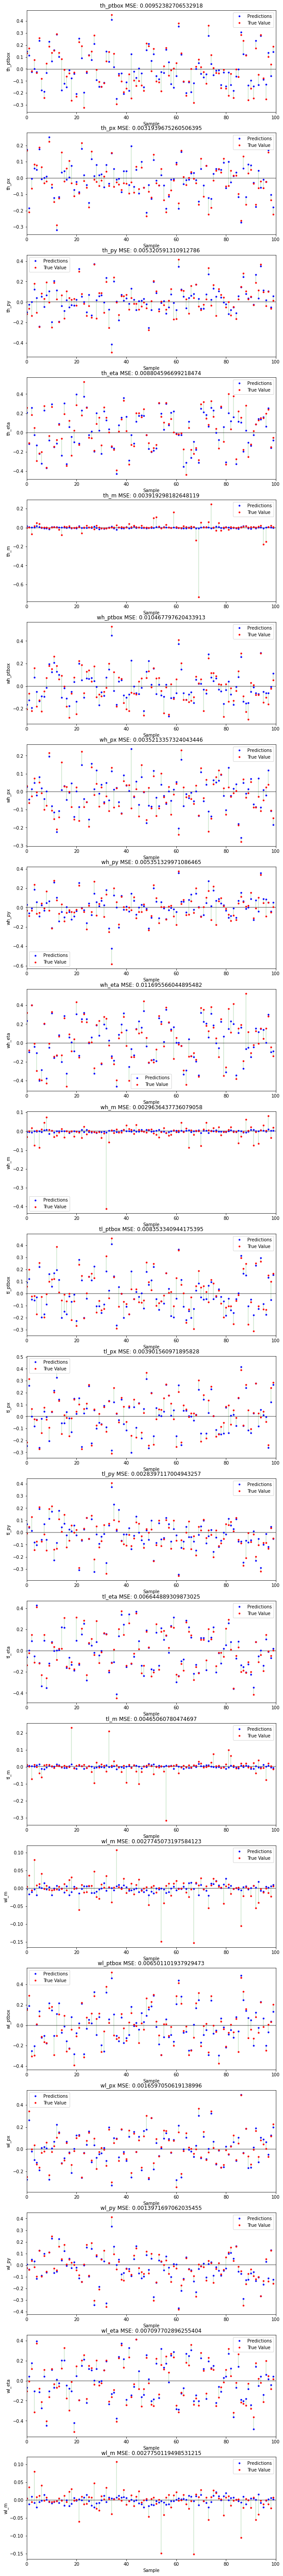

In [13]:
Analysis.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

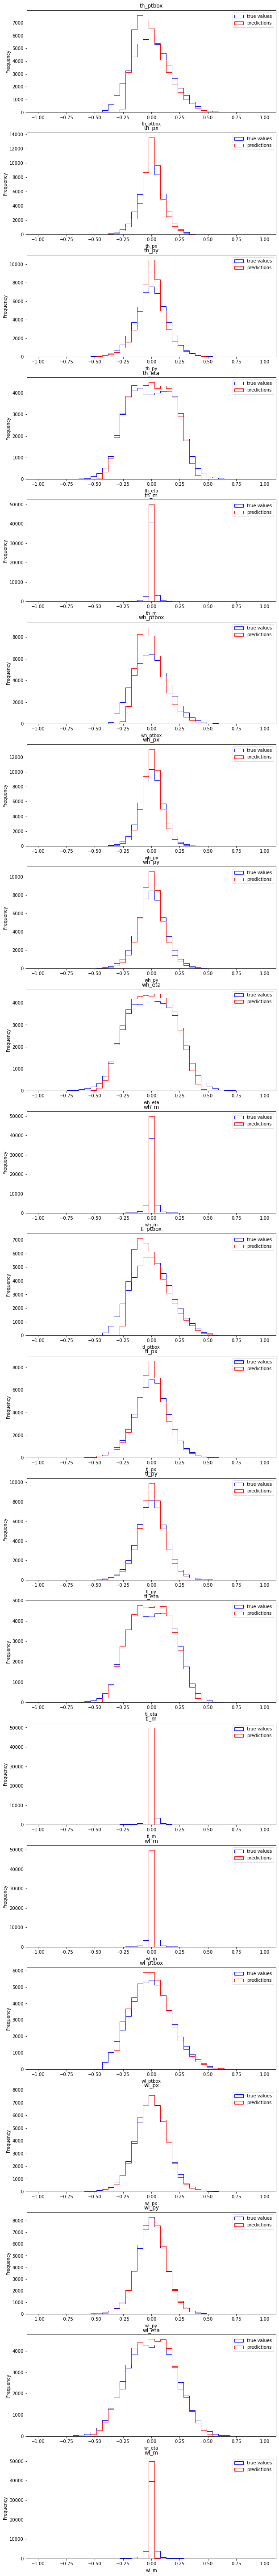

In [14]:
Analysis.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

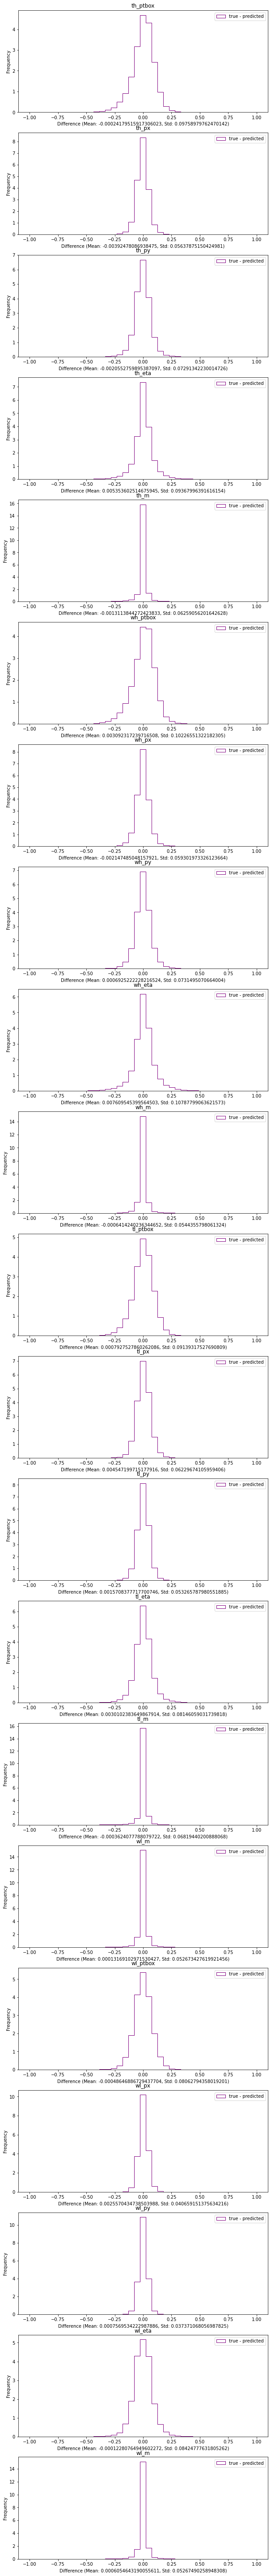

In [15]:
Analysis.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

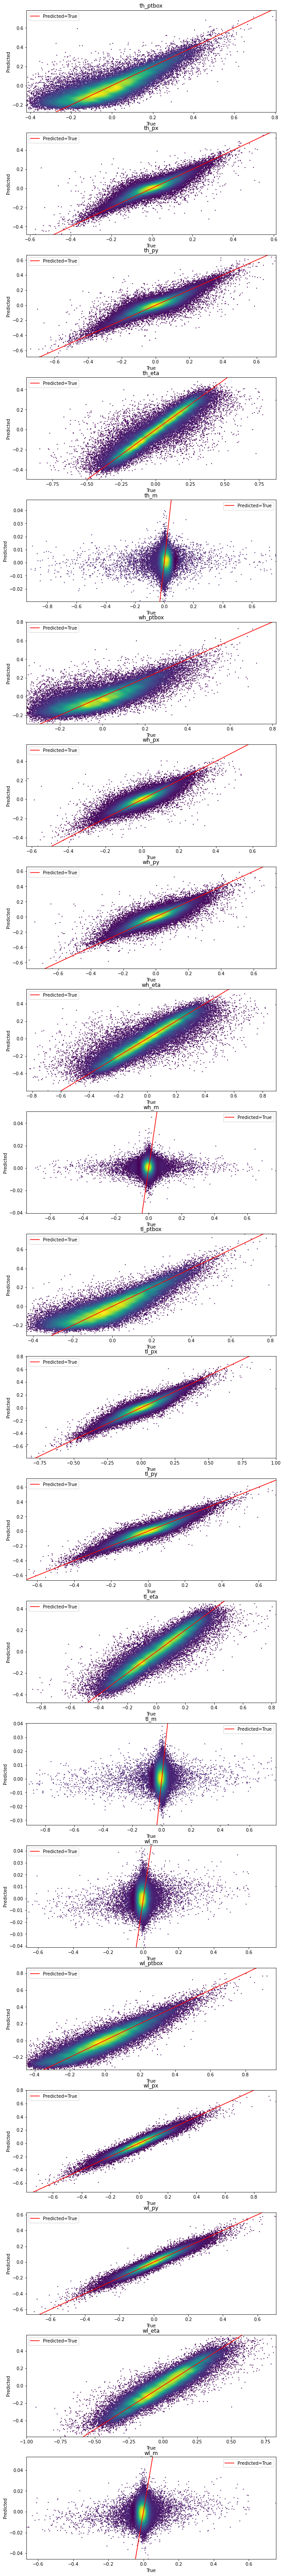

In [16]:
Analysis.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

 # Original scale plots

In [17]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 299.9650098168707
 
th_pt MSE :  1637.1752250802
th_eta MSE :  0.5222278906
th_phi MSE :  0.8165873210
th_m MSE :  32.8837507865
wh_pt MSE :  1347.8638298669
wh_eta MSE :  0.4993464947
wh_phi MSE :  0.7897237312
wh_m MSE :  28.0554855501
tl_pt MSE :  1343.8689828950
tl_eta MSE :  0.4193515833
tl_phi MSE :  0.5301130842
tl_m MSE :  39.1071110454
wl_m MSE :  35.8569469138
wl_pt MSE :  587.8285976366
wl_eta MSE :  0.2964870359
wl_phi MSE :  0.1931579442
wl_m MSE :  35.8634686102


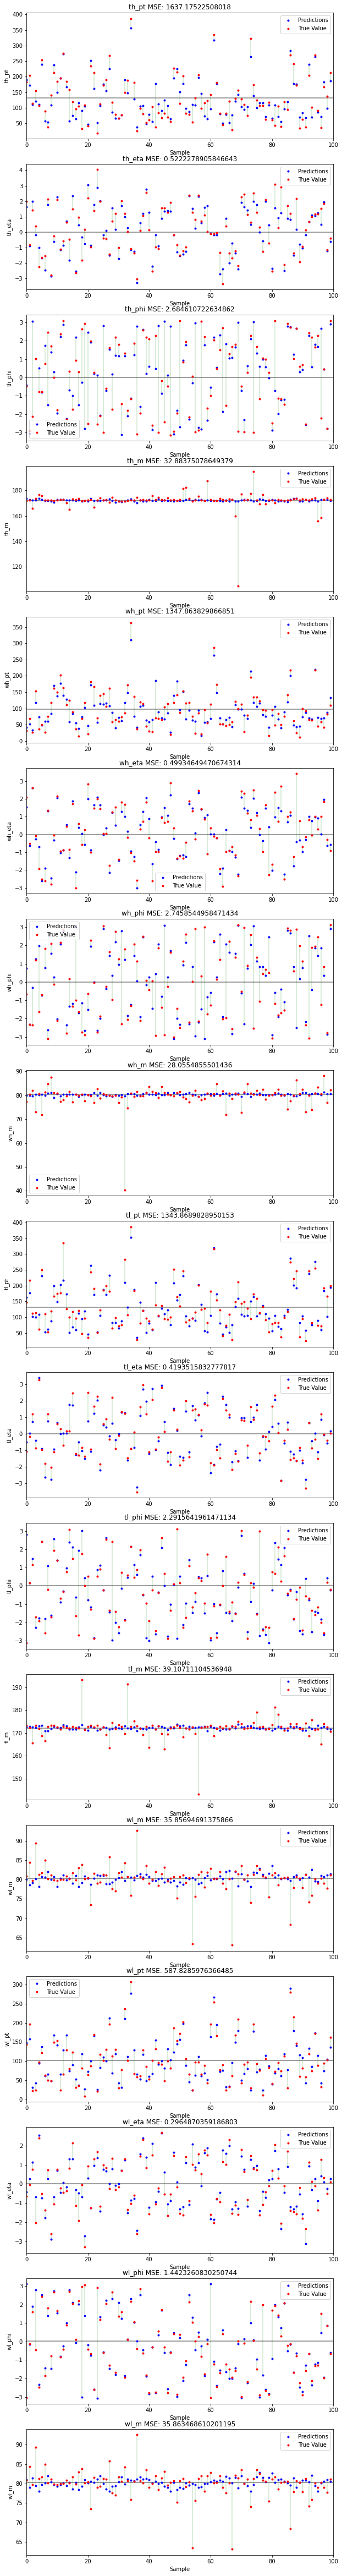

In [18]:
Analysis.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

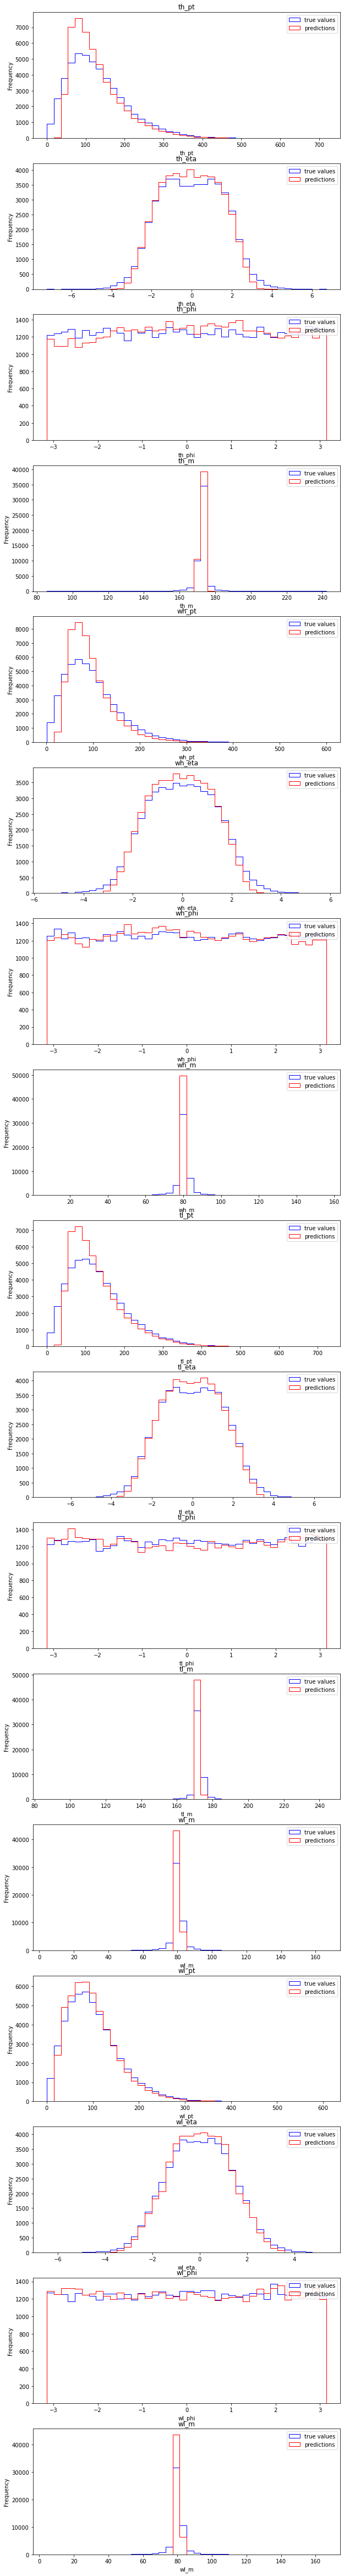

In [19]:
Analysis.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

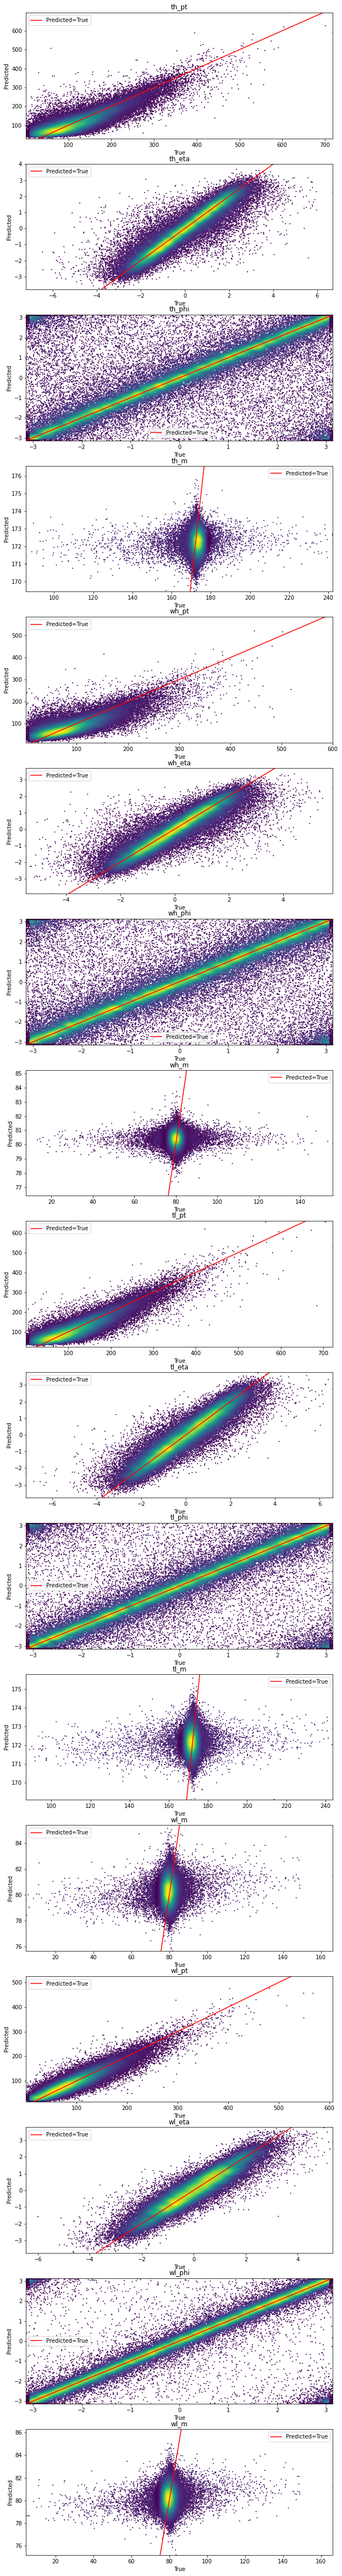

In [20]:
Analysis.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)

# Observables

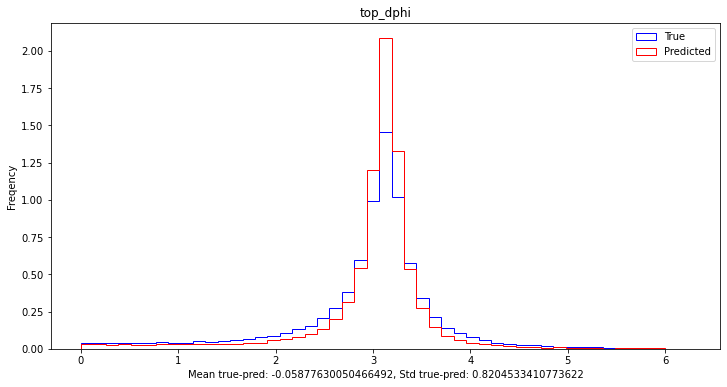

In [21]:
import observables 
import importlib
importlib.reload(observables)
truths = observables.fill_observables(true_origscale, True, Y_keys)
preds = observables.fill_observables(predictions_origscale, False, Y_keys)

# top_dphi=np.abs(th_phi-tl_phi)
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_dphi'], preds['top_dphi'])

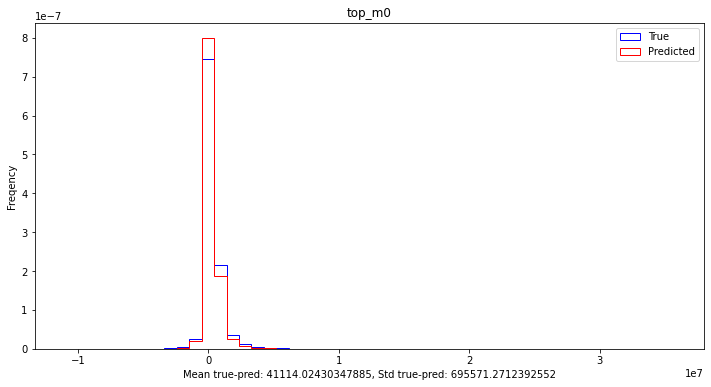

In [22]:
# top_m0= th_m**2-th_p**2 + tl_m**2-tl_p**2
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_m0'],preds['top_m0'])

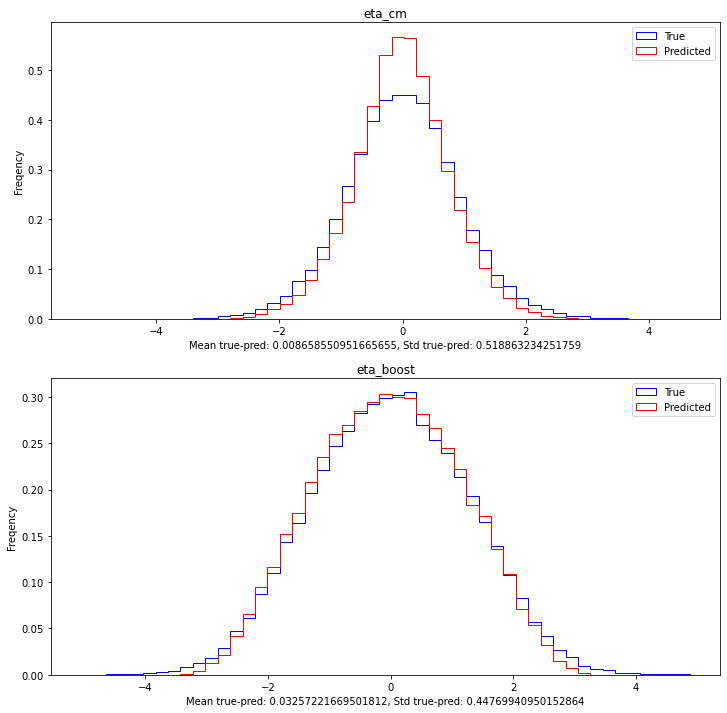

In [23]:
# eta_cm=0.5*(th_eta-tl_eta), eta_boost=0.5*(th_eta+tl_eta)
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['eta_cm'], preds['eta_cm'])
plt.subplot(212)
observables.plot_hist(truths['eta_boost'], preds['eta_boost'])


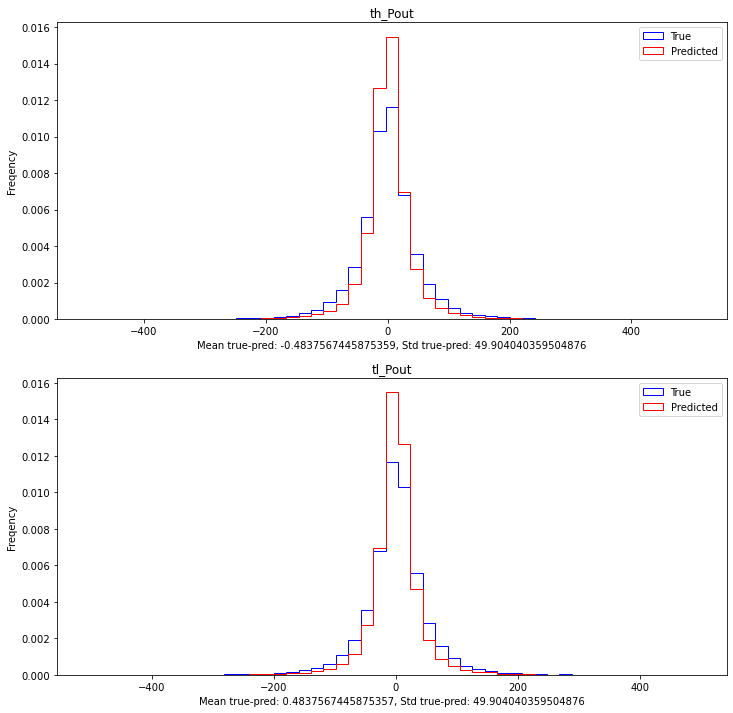

In [24]:
# th_Pout=dot(th_P, cross(tl_P,ez)/norm(tl_P,ez)), tl_Pout=dot(tl_P, cross(th_P,ez)/norm(th_P,ez))
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['th_Pout'], preds['th_Pout'])
plt.subplot(212)
observables.plot_hist(truths['tl_Pout'], preds['tl_Pout'])


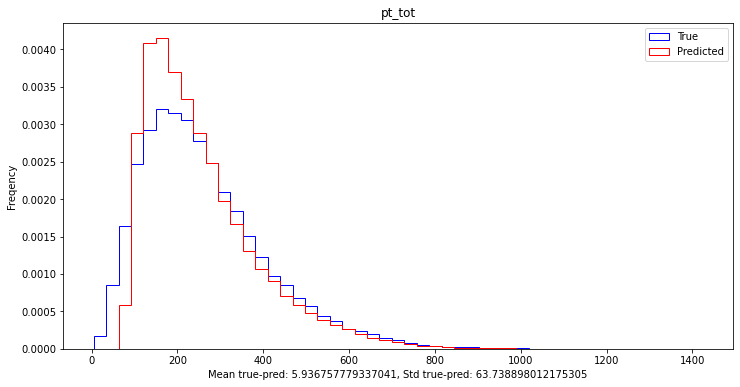

In [25]:
# pt_tot = th_pt+tl_pt
plt.figure(figsize=(12,6))
observables.plot_hist(truths['pt_tot'],preds['pt_tot'])

In [26]:
model.save('Jet_Reweight_cartpt.keras')